In [1]:
from time import time

In [2]:
tic = time()

In [4]:
from ship_routing.core import Route, WayPoint
from ship_routing.data import load_currents

In [5]:
import numpy as np
import tqdm
import pandas as pd
import shapely
import warnings
from random import choice
from functools import reduce
from copy import deepcopy, copy

In [6]:
from matplotlib import pyplot as plt
import cartopy

In [7]:
# parameters
resolution = 1_000_000
perturbation_step = 500_000
duration = 14 * 24 * 3600
random_seed = 1234
population_size = 100
keep_best_percent = 20
num_generations = 4
num_refinements = 2

In [8]:
np.random.seed(random_seed)

In [9]:
currents = load_currents(
    "data/currents/cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_2021-01_100W-020E_10N-65N.nc"
)
currents = currents.where(
    (currents.lon > currents.lon.min())
    & (currents.lon < currents.lon.max())
    & (currents.lat > currents.lat.min())
    & (currents.lat < currents.lat.max())
)
currents["speed"] = (currents.to_array() ** 2).sum("variable") ** 0.5
currents = currents.where(currents.speed > 0)
currents = currents.compute()

In [10]:
route_ref = Route(
    way_points=(
        WayPoint(lon=-76.5, lat=34, time=np.datetime64("2021-01-01")),
        WayPoint(
            lon=-10,
            lat=40,
            time=np.datetime64("2021-01-01") + np.timedelta64(duration, "s"),
        ),
    )
).refine(distance_meters=resolution)
route_ref

Route(way_points=(WayPoint(lon=-76.5, lat=34, time=numpy.datetime64('2021-01-01')), WayPoint(lon=-66.72324582363196, lat=37.61882609793096, time=numpy.datetime64('2021-01-03T07:59:59.999')), WayPoint(lon=-56.08181739926721, lat=40.35139119421844, time=numpy.datetime64('2021-01-05T15:59:59.999')), WayPoint(lon=-44.72734499762553, lat=42.03357654925816, time=numpy.datetime64('2021-01-07T23:59:59.999')), WayPoint(lon=-32.9780534261577, lat=42.546589567903126, time=numpy.datetime64('2021-01-10T07:59:59.999')), WayPoint(lon=-21.26269620977193, lat=41.85106371408407, time=numpy.datetime64('2021-01-12T15:59:59.999')), WayPoint(lon=-10.0, lat=40, time=numpy.datetime64('2021-01-15T00:00:00'))))

In [11]:
np.mean([l.speed_ms for l in route_ref.legs]) / currents.speed.quantile(0.95).data[
    ()
], np.mean([l.speed_ms for l in route_ref.legs]), currents.speed.quantile(0.95).data[()]

(10.036682239627313, 4.81100185935232, 0.47934185266494644)

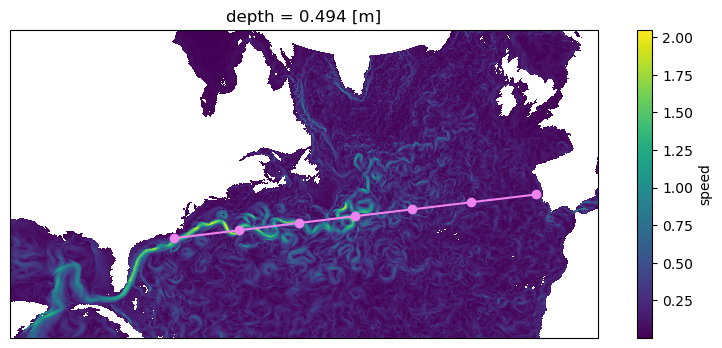

In [12]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(10, 4),
    subplot_kw={
        "projection": cartopy.crs.Gnomonic(
            central_longitude=np.mean(route_ref.line_string.xy[0]),
            central_latitude=np.mean(route_ref.line_string.xy[1]),
        )
    },
)
currents.speed.mean("time").plot(ax=ax, transform=cartopy.crs.PlateCarree())
ax.plot(
    *route_ref.line_string.xy,
    marker="o",
    color="violet",
    transform=cartopy.crs.PlateCarree(),
)
ax.set_extent([-90, -10, 20, 60])

In [13]:
population = [deepcopy(route_ref) for n in range(population_size)]
cost = [i.cost_through(currents) for i in population]

In [14]:
def perturb_population(pop, max_step=100_000, num_retry=10):
    pop2 = []
    cost_list = []
    for n in tqdm.tqdm(range(len(population))):
        individual = pop[n]
        cost = individual.cost_through(current_data_set=currents)
        for nret in range(num_retry):
            for npert in range(int(np.random.triangular(1, 1, len(individual) - 1))):
                nwp = np.random.randint(1, len(individual) - 1)
                # modify 80..100 deg portside / starbord
                az = individual.waypoint_azimuth(n=nwp)
                az_mod = az + np.random.uniform(80, 100)  # always to starbord
                _individual = individual.move_waypoint(
                    azimuth_degrees=az_mod,
                    n=nwp,
                    distance_meters=np.random.normal(
                        0, max_step
                    ),  # sign is handled here
                )
            _dist = np.linspace(0, _individual.length_meters, len(_individual))
            _individual = _individual.resample_with_distance(distances_meters=_dist)
            _cost = _individual.cost_through(current_data_set=currents)
            if not np.isnan(_cost):
                individual = _individual
                cost = _cost
                break
        pop2.append(individual)
        cost_list.append(cost)
    return pop2, cost_list

In [15]:
def replicate(population=None, cost=None, keep_best_percent=50, size=None):
    cost_threshold = np.quantile(
        np.array(cost)[~np.isnan(np.array(cost))], keep_best_percent / 100
    )
    pop_filtered = [i for i, c in zip(population, cost) if c < cost_threshold]
    pop_replicated = [choice(pop_filtered) for n in range(size)]
    cost_replicated = [i.cost_through(currents) for i in pop_replicated]
    return pop_replicated, cost_replicated

The following "warms up" the population.

In [16]:
population, cost = perturb_population(population, max_step=perturbation_step)
population, cost = perturb_population(population, max_step=perturbation_step)
population, cost = perturb_population(population, max_step=perturbation_step)
population.append(route_ref)
cost.append(route_ref.cost_through(currents))

100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 36.38it/s]


In [17]:
population_generations = [
    copy(population),
]

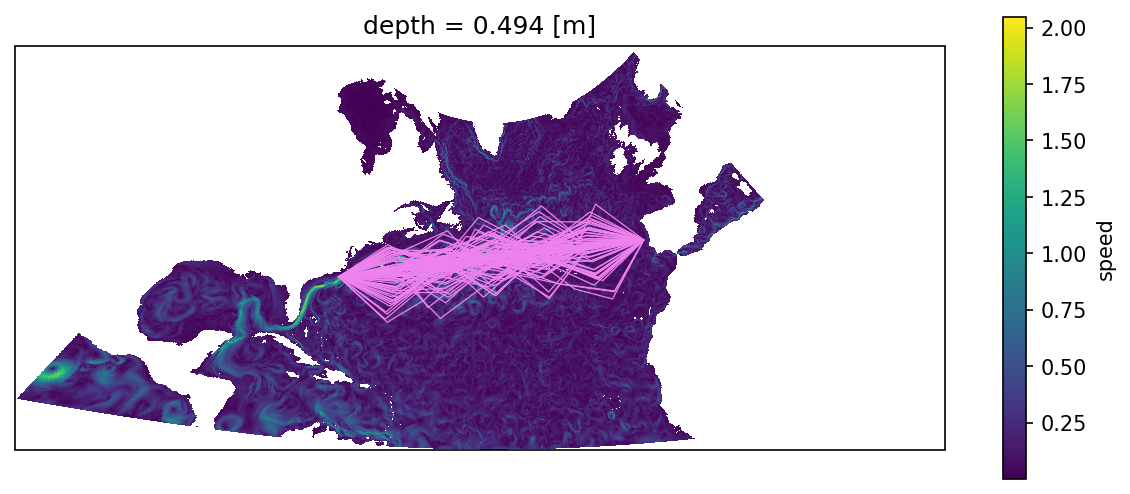

In [18]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(10, 4),
    subplot_kw={
        "projection": cartopy.crs.Gnomonic(
            central_longitude=np.mean(route_ref.line_string.xy[0]),
            central_latitude=np.mean(route_ref.line_string.xy[1]),
        )
    },
)
fig.set_dpi(150)
currents.speed.mean("time").plot(ax=ax, transform=cartopy.crs.PlateCarree())
for indv in population:
    ax.plot(
        *indv.line_string.xy,
        color="violet",
        linewidth=0.6,
        transform=cartopy.crs.PlateCarree(),
    )
# ax.set_extent([-90, -10, None, None])

Then, we run evolution with only the best XX% being retained.

In [19]:
for nref in range(num_refinements):
    resolution /= 2
    perturbation_step /= 2
    population_size = int(population_size * 1)
    population = [i.refine(distance_meters=resolution) for i in population]
    population = [choice(population) for npop in range(population_size)]

    for ngen in range(num_generations):
        _population, _cost = perturb_population(population, max_step=perturbation_step)
        population, cost = replicate(
            2 * _population + population,
            2 * _cost + cost,
            keep_best_percent=keep_best_percent,
            size=population_size,
        )
        population_generations.append(copy(population))

100%|█████████████████████████████████████████| 100/100 [00:12<00:00,  7.74it/s]


In [20]:
cost_generations = [
    [r.refine(resolution).cost_through(currents) for r in tqdm.tqdm(_pop)]
    for _pop in population_generations
]

100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 20.21it/s]


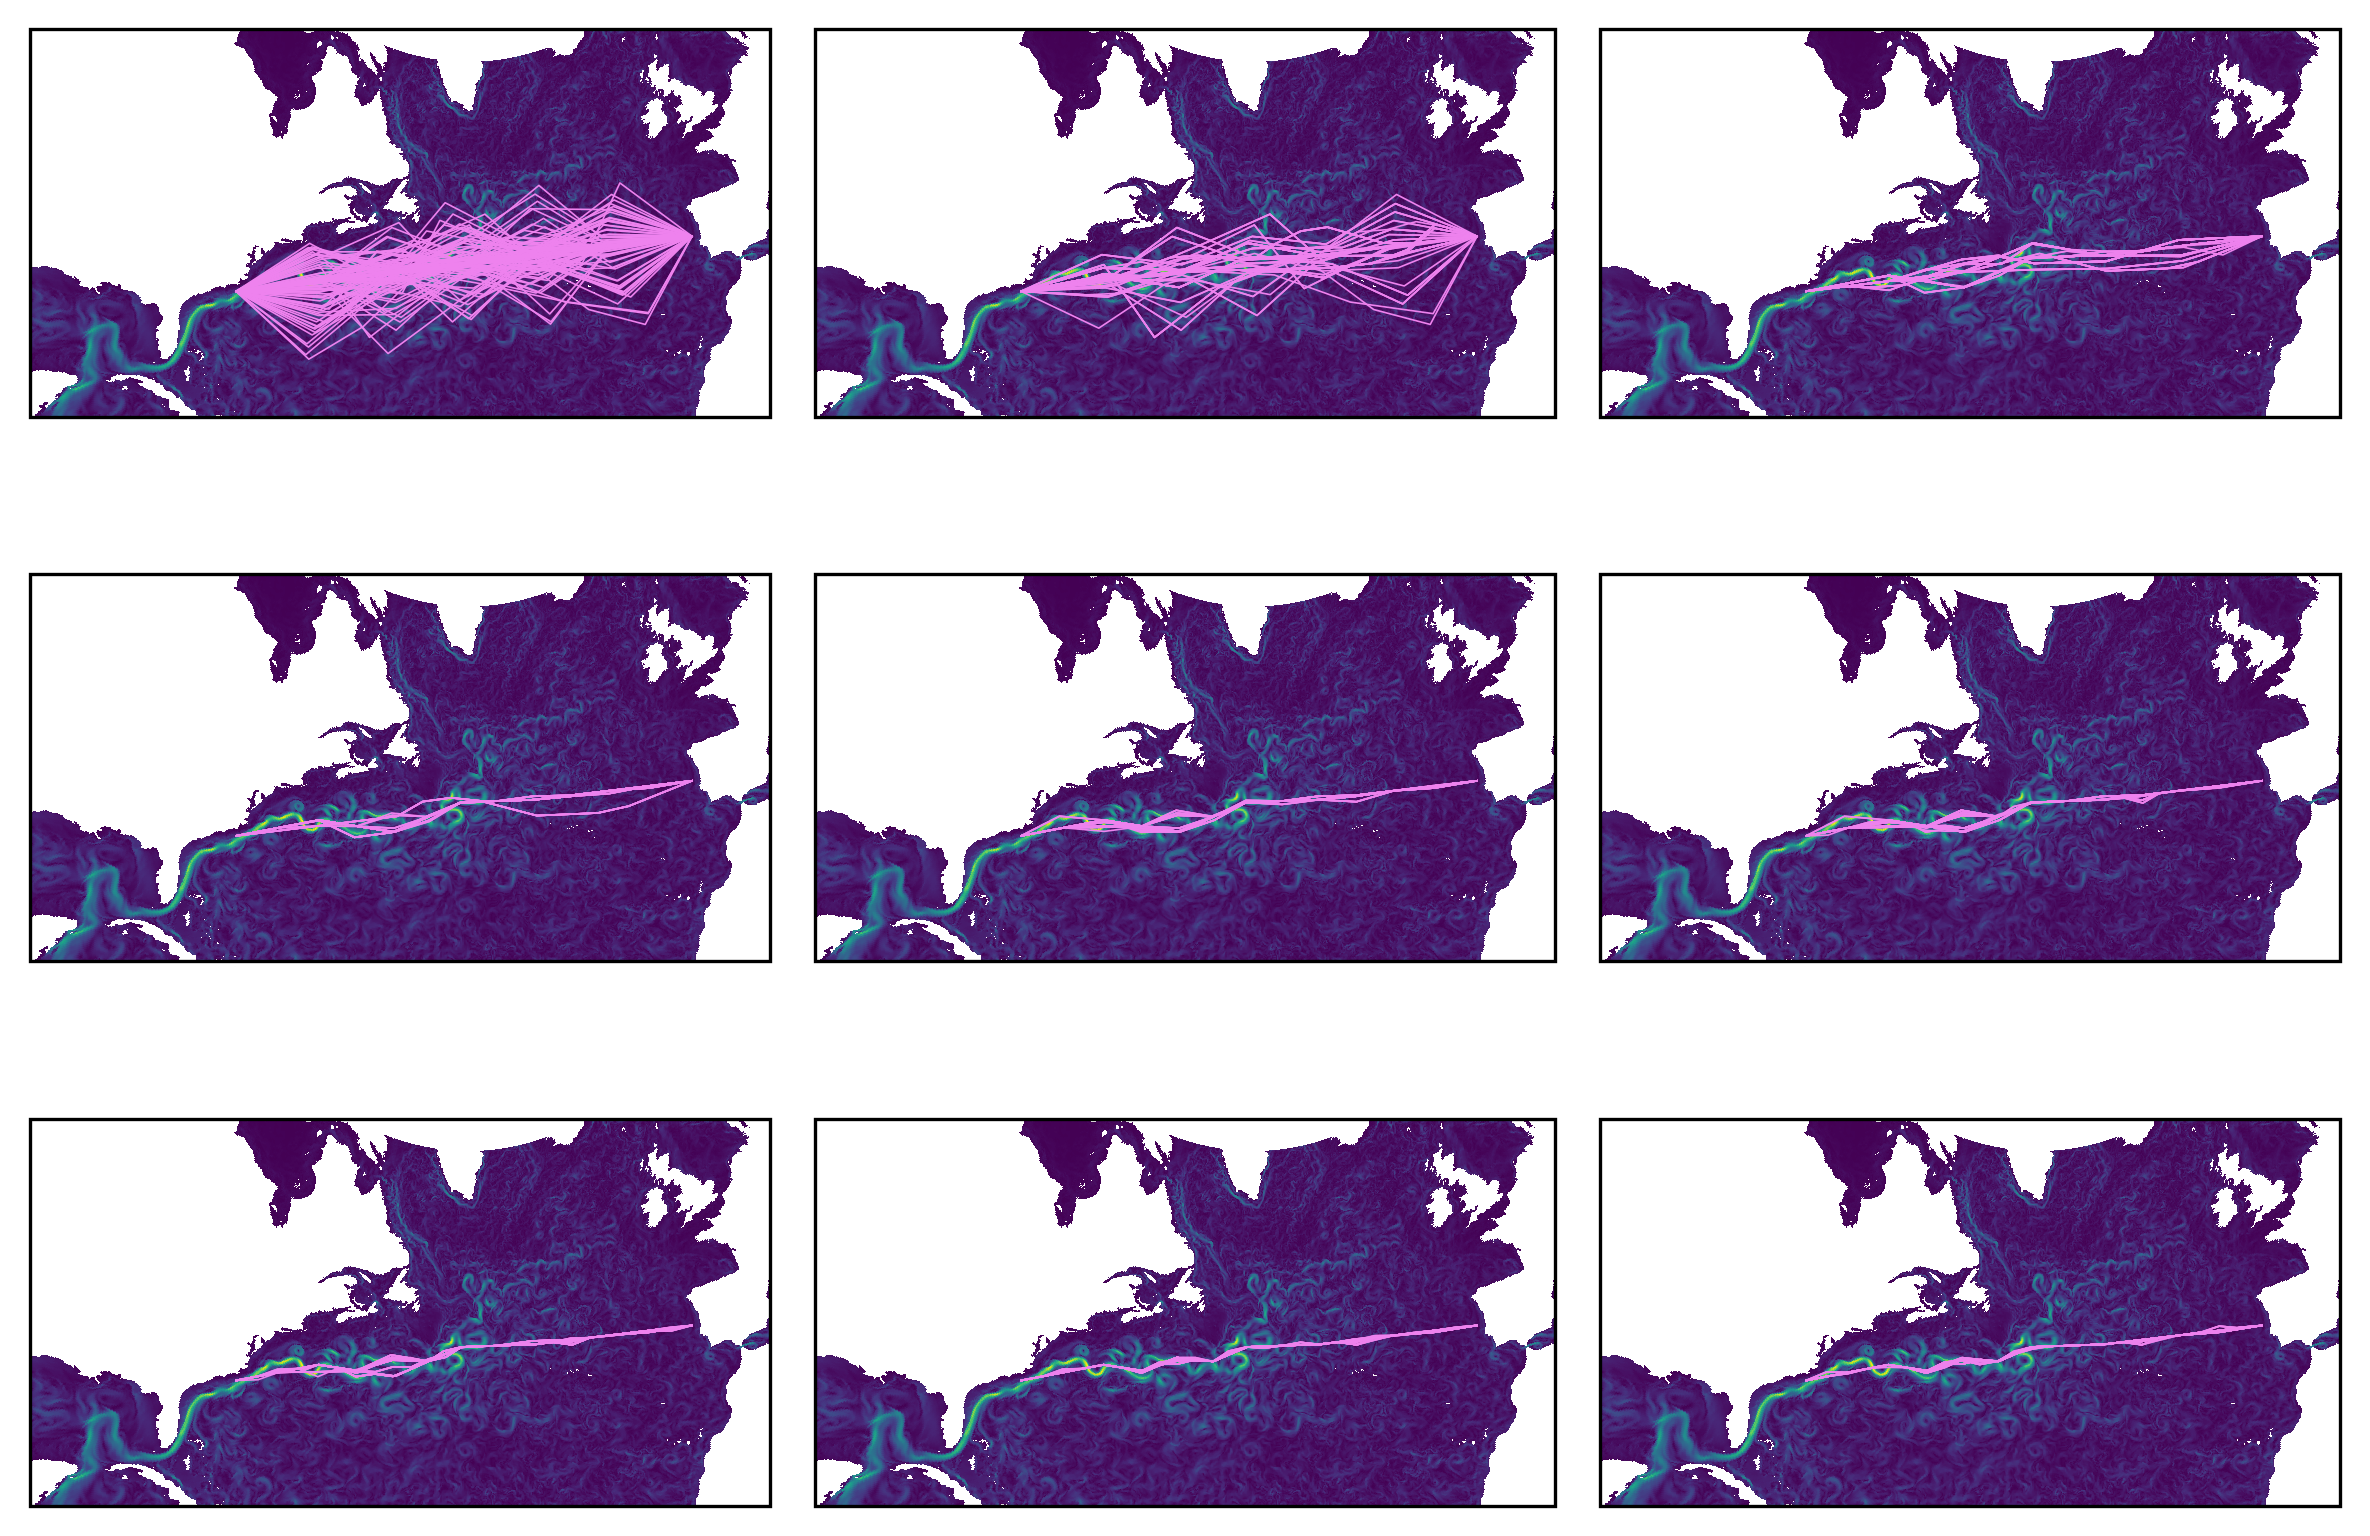

In [21]:
fig, ax = plt.subplots(
    3,
    3,
    figsize=(8, 6),
    subplot_kw={
        "projection": cartopy.crs.Gnomonic(
            central_longitude=np.mean(route_ref.line_string.xy[0]),
            central_latitude=np.mean(route_ref.line_string.xy[1]),
        )
    },
)
fig.set_dpi(300)
for pop, _ax in zip(population_generations, ax.flatten()):
    currents.speed.plot(ax=_ax, transform=cartopy.crs.PlateCarree(), add_colorbar=False)
    for indv in pop:
        _ax.plot(
            *indv.line_string.xy,
            color="violet",
            linewidth=0.4,
            transform=cartopy.crs.PlateCarree(),
        )
    _ax.set_title("")
    _ax.set_extent([-90, -10, 20, 60])
fig.tight_layout()

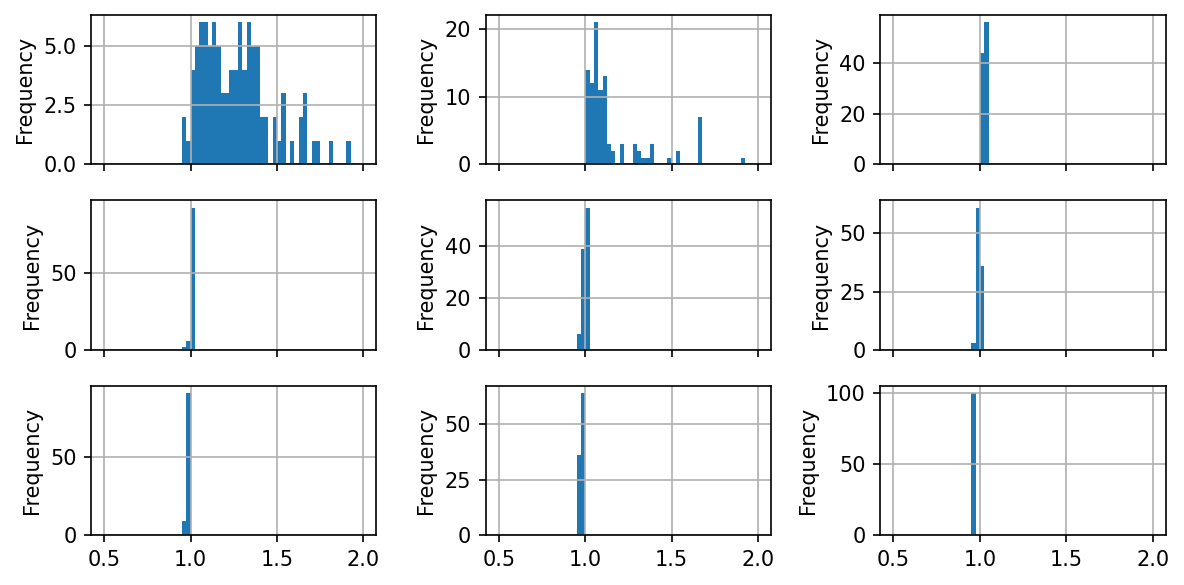

In [22]:
fig, ax = plt.subplots(
    3,
    3,
    figsize=(8, 4),
    sharex=True,
    sharey=False,
)
fig.set_dpi(150)
for _cost, _ax in zip(cost_generations, ax.flatten()):
    (
        pd.Series(_cost)
        / route_ref.refine(distance_meters=resolution).cost_through(currents)
    ).plot.hist(bins=np.linspace(0.5, 2, 61), ax=_ax, grid=True)
fig.tight_layout()

In [23]:
print("took", time() - tic, "seconds")

took 192.07492589950562 seconds


<Axes: ylabel='Frequency'>

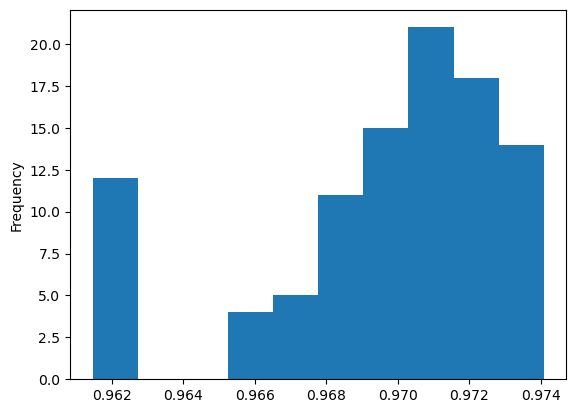

In [24]:
(pd.Series(cost) / route_ref.refine(resolution).cost_through(currents)).plot.hist()

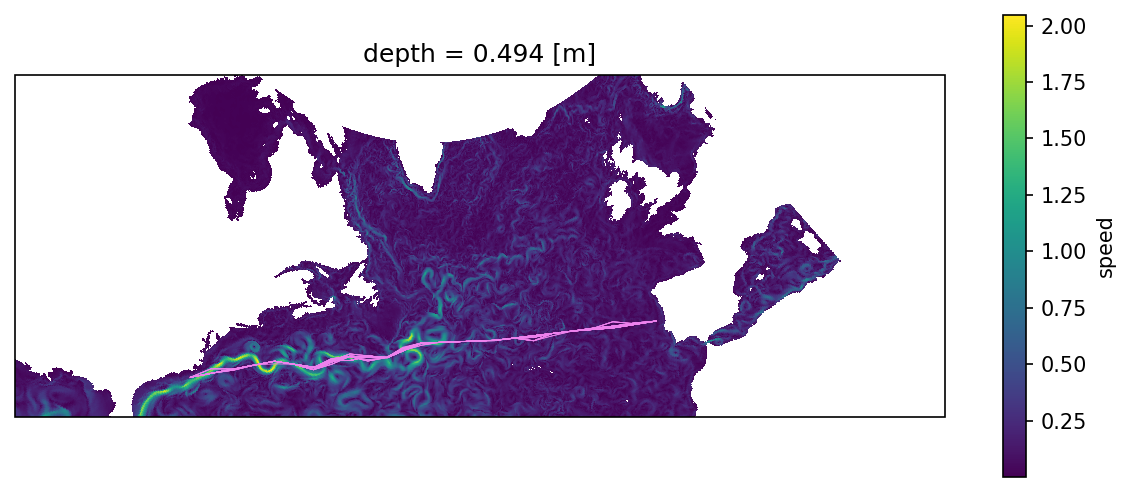

In [25]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(10, 4),
    subplot_kw={
        "projection": cartopy.crs.Gnomonic(
            central_longitude=np.mean(route_ref.line_string.xy[0]),
            central_latitude=np.mean(route_ref.line_string.xy[1]),
        )
    },
)
fig.set_dpi(150)
currents.speed.mean("time").plot(ax=ax, transform=cartopy.crs.PlateCarree())
for indv in population:
    ax.plot(
        *indv.line_string.xy,
        color="violet",
        linewidth=0.4,
        transform=cartopy.crs.PlateCarree(),
    )
ax.set_extent([-90, 10, 25, 60])

In [26]:
pd.Series([r.length_meters for r in population]).median() / route_ref.length_meters

1.012179716471039